<a href="https://colab.research.google.com/github/Eitams/NLP_Exercise/blob/main/NLP_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text analysis - Bacteria VS Bactriophage

In [48]:
# # #Upgrade profiling library and "Restart runtime"
# !pip install --upgrade pandas-profiling
# !pip install langdetect
# !pip install spacy
# !pip install --upgrade spacy
# !pip install scattertext
# !spacy download en_core_web_lg
# !pip install WordCloud
# !pip install pip install markupsafe==2.0.1

In [49]:
## Set working directory
from google.colab import drive
drive.mount('/content/drive')
#import os
#os.chdir('/content/drive/MyDrive/NLP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
## Attached git reseparatory to download extracted data from
!git clone https://github.com/Eitams/NLP_Exercise.git 

fatal: destination path 'NLP_Exercise' already exists and is not an empty directory.


In [51]:
## Import packeges
## For Data processing
import pandas as pd
import numpy as np
import collections
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 30

import pandas_profiling as prof
from pathlib import Path

## For plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go

import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.core.interactiveshell import InteractiveShell

## Text processing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud 

## for Named-entity recognition (NER)
import spacy

## for sentiment
from textblob import TextBlob

## for language detection
import langdetect

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
## Loading data from git
df_bacteria = pd.read_csv("NLP_Exercise/data/bacteria_df.csv", index_col=0)
df_phage = pd.read_csv("NLP_Exercise/data/bacteriophage_df.csv", index_col=0)

In [53]:
# Dropping first row of df_phage (Its the general discription and not phage type)
df_phage.drop(index = 0, inplace = True)
df_phage.head()

,Name,Description
1,Bacillus virus AP50,Bacillus virus AP50 is a species of bacteriophage that infects Bacillus anthracis bacteria. Orig...
2,Bacteriophage AP205,Bacteriophage AP205 is a bacteriophage that infects Acinetobacter bacteria. Contains a genome li...
3,Bacteriophage f2,"Bacteriophage f2 is an icosahedral, positive-sense single-stranded RNA virus that infects the ba..."
4,Bacteriophage MS2,"Bacteriophage MS2 (Emesvirus zinderi), commonly called MS2, is an icosahedral, positive-sense si..."
5,Bacteriophage Mu,"Bacteriophage Mu, also known as mu phage or mu bacteriophage, is a muvirus (the first of its kin..."


In [54]:
'''
Merge data into 1 data frame
'''
## Add type column
df_bacteria["Type"] = "Bacteria" 
df_phage["Type"] = "Bacteriophage" 

## Merge df
df = pd.concat([df_bacteria, df_phage])

In [55]:
print("Dataframe dimensions: {}".format(df.shape))
df.head()

Dataframe dimensions: (179, 3)


,Name,Description,Type
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria
2,Agrobacterium tumefaciens,Agrobacterium radiobacter (more commonly known as Agrobacterium tumefaciens) is the causal agent...,Bacteria
3,Anaplasma,"Anaplasma is a genus of bacteria of the alphaproteobacterial order Rickettsiales, family Anaplas...",Bacteria
4,Anaplasma phagocytophilum,Anaplasma phagocytophilum (formerly Ehrlichia phagocytophilum) is a Gram-negative bacterium that...,Bacteria


In [56]:
## Initial phase report EDA
#profile = prof.ProfileReport(df, title="Profile Report wikipedia pages", explorative=True)
#profile.to_file(Path("First_profile_report_wikipedia.html"))

Key insights:  
- There are no missing data values in any of the columns.    
- The Type column is unbalanced, we will plot it again in the following step.  
- No data is repeating itself.

## Exploratory data analysis

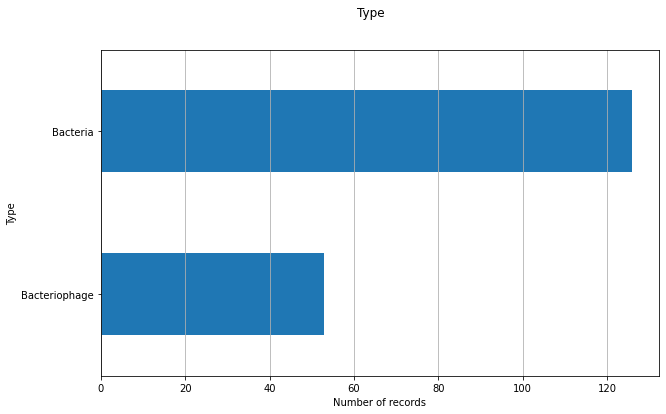

In [57]:
## Exploring the distribution of the "Type" column
x = "Type" 
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
ax.set_xlabel("Number of records")
plt.show()

Key insights:  
The data is unbalanced, in future work we may decide to resample it.

In [58]:
## Detecting the language the text is writting in
df['lang'] = df["Description"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
print(df["lang"].unique()) ## Print unique values in language column

['en']


Key insights:  
As expected  all pages detected as written in english (we only downloaded pages from the english wikipedia).

## Text Preprocessing

In [59]:
'''
Function which remove html tags from text string.
'''
def utils_basic_clean(text):
    ## clean ( Remove HTML tags)
    text = str(text).replace("(<br/>)", "") ## line break element
    text = text.replace('(<a).*(>).*(</a>)', '') ## Hyperlink tag
    text = text.replace('(&amp)', '')
    text = text.replace('(&gt)', '')
    text = text.replace('(&lt)', '')
    text = text.replace('(\xa0)', ' ') 
    
    return(text)



'''
Function which preprocess a text string:
Lower case, remove punctuation and stopwords, lemmatization or stemming)
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then remove leading and trailing whitespaces)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [60]:
## Creating a list of stopwords (usnig NLTK packege) to remove from text
lst_stopwords = nltk.corpus.stopwords.words("english")
print(lst_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [61]:
## Apply basic cleaning on Description column
df["Description"] = df["Description"].apply(lambda x: utils_basic_clean(x))

## Apply cleaning and preprocessing on Description column using utils function with lemmatization of words -saving as a new column-
df["Description_clean"] = df["Description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [62]:
df.head()

,Name,Description,Type,lang,Description_clean
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria,en,acinetobacter baumannii typically short almost round rodshaped coccobacillus gramnegative bacter...
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria,en,actinomyces israelii specie grampositive rodshaped bacteria within genus actinomyces known live ...
2,Agrobacterium tumefaciens,Agrobacterium radiobacter (more commonly known as Agrobacterium tumefaciens) is the causal agent...,Bacteria,en,agrobacterium radiobacter commonly known agrobacterium tumefaciens causal agent crown gall disea...
3,Anaplasma,"Anaplasma is a genus of bacteria of the alphaproteobacterial order Rickettsiales, family Anaplas...",Bacteria,en,anaplasma genus bacteria alphaproteobacterial order rickettsiales family anaplasmataceae anaplas...
4,Anaplasma phagocytophilum,Anaplasma phagocytophilum (formerly Ehrlichia phagocytophilum) is a Gram-negative bacterium that...,Bacteria,en,anaplasma phagocytophilum formerly ehrlichia phagocytophilum gramnegative bacterium unusual trop...


## Feature engineering

### Length analysis

In [63]:
## Calculating new features from raw data column (Description)
## Word count
df['word_count'] = df["Description"].apply(lambda x: len(str(x).split(" ")))
## Character count
df['char_count'] = df["Description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
## sentence count
df['sentence_count'] = df["Description"].apply(lambda x: len(str(x).split(".")))
## average word length
df['avg_word_length'] = df['char_count'] / df['word_count']
## average sentence length
df['avg_sentence_length'] = df['word_count'] / df['sentence_count']

## Calculating length of Name column
## Word count
df['name_word_count'] = df["Name"].apply(lambda x: len(str(x).split(" ")))
## Character count
df['name_char_count'] = df["Name"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
## average word length
df['name_avg_word_length'] = df['name_char_count'] / df['name_word_count']
df.head(2)

,Name,Description,Type,lang,Description_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,name_word_count,name_char_count,name_avg_word_length
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria,en,acinetobacter baumannii typically short almost round rodshaped coccobacillus gramnegative bacter...,354,2118,27,5.983051,13.111111,2,22,11.0
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria,en,actinomyces israelii specie grampositive rodshaped bacteria within genus actinomyces known live ...,72,383,6,5.319444,12.000000,2,19,9.5


In [64]:
'''
Function which plot the histogram and distplot of group types
'''
def hist_compare(colum):
  x, y = colum, "Type"
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize= (20,5))
  fig.suptitle(x, fontsize=12)
  colors = ['#1f78b4', '#b2df8a']

  for c, i in zip(colors, df[y].unique()):
      sns.histplot(df[df[y]==i][x], bins=10, color=c, ax=ax[0])
      sns.kdeplot(df[df[y]==i][x], ax=ax[1], color=c)
  sns.boxplot(x=df[y], y=df[x], palette=colors, ax=ax[2])


  ax[0].grid(True)
  ax[0].legend(df[y].unique())
  ax[1].grid(True)
  plt.show()

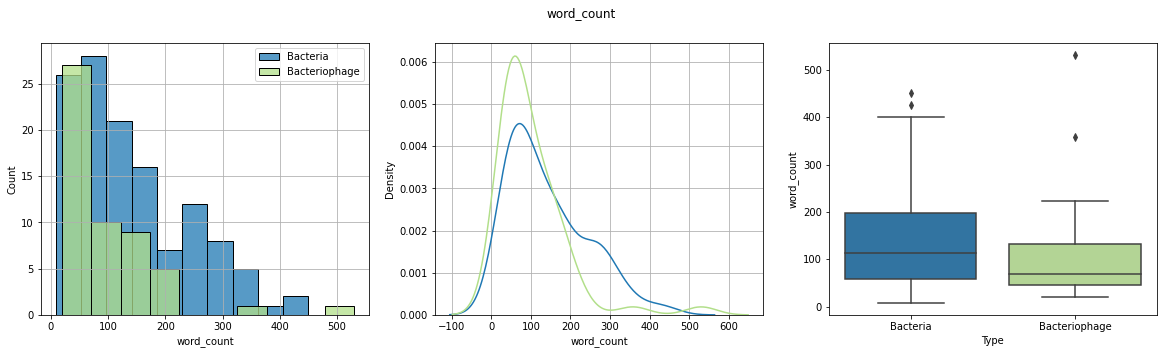

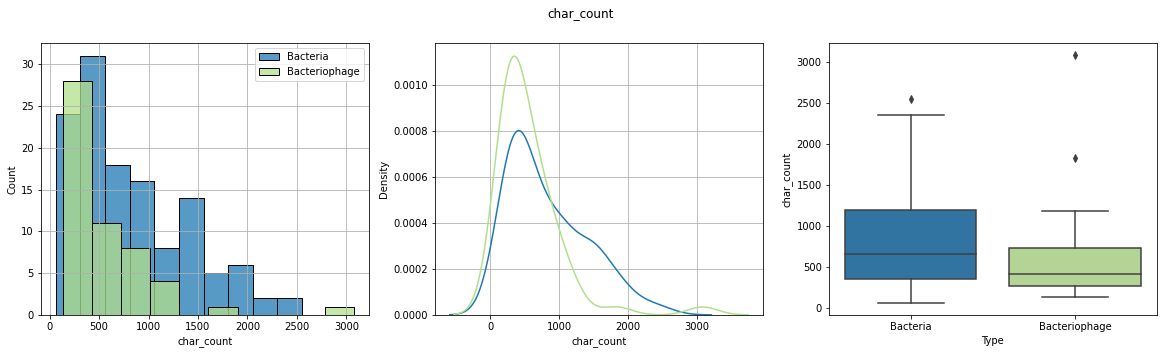

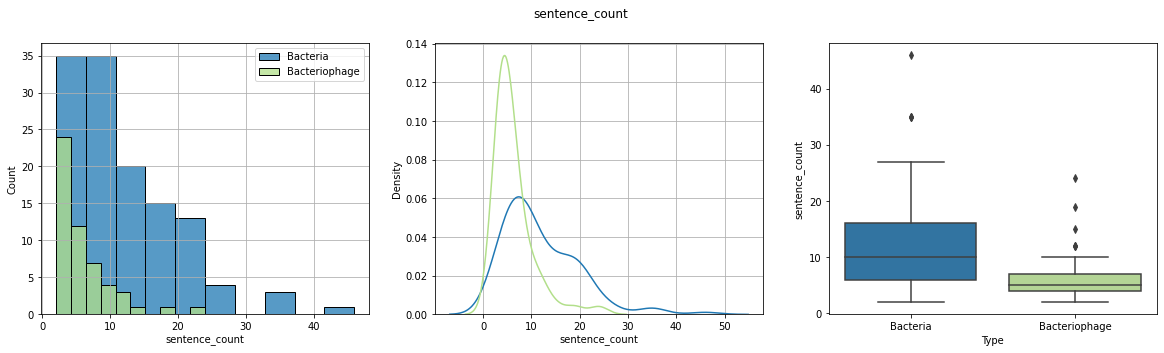

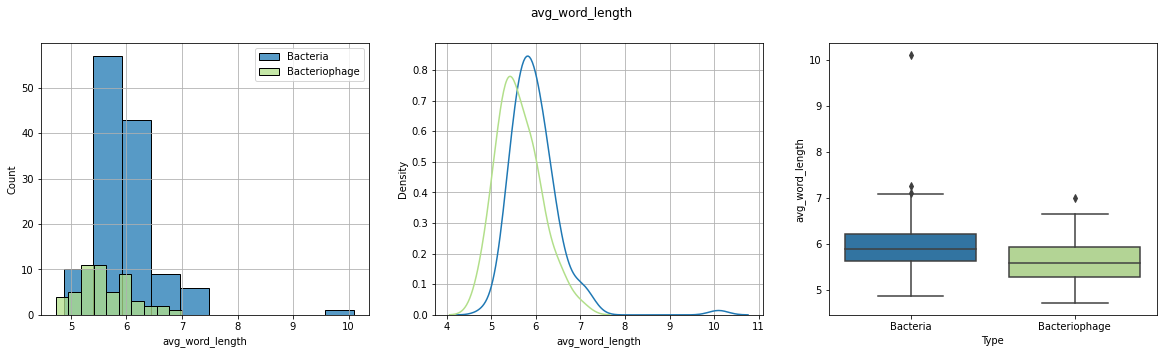

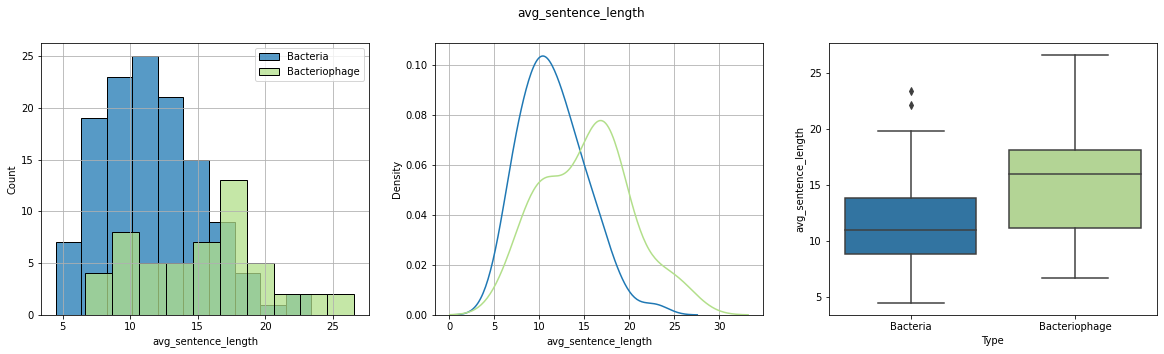

In [65]:
## Plot Description column length features 
hist_compare("word_count")
hist_compare("char_count")
hist_compare("sentence_count")
hist_compare("avg_word_length")
hist_compare("avg_sentence_length")

Key insights:  
The density plot distribution represent the data beter in this case due to it's unbalnced nature.  
A differance in groups density distribution is notecible at the word count, char count and sentance count, were, as an example the probability for the value to be bigger then ~200 , ~1000 and ~10  respectively is higher for the bacteria group then for the bacteriophage group.  
An opposite relation is visibale for the avg sentence length.


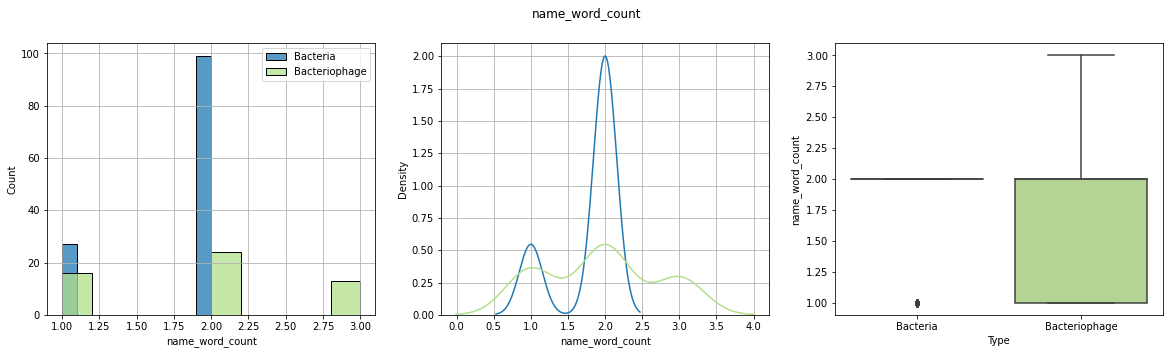

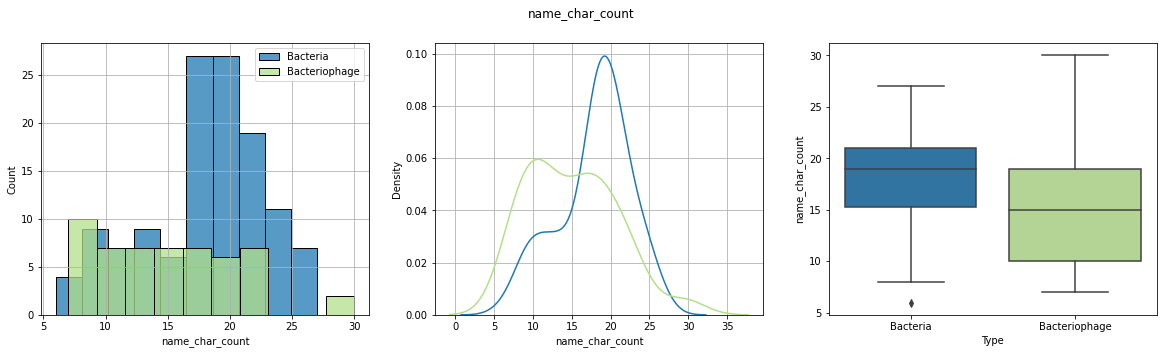

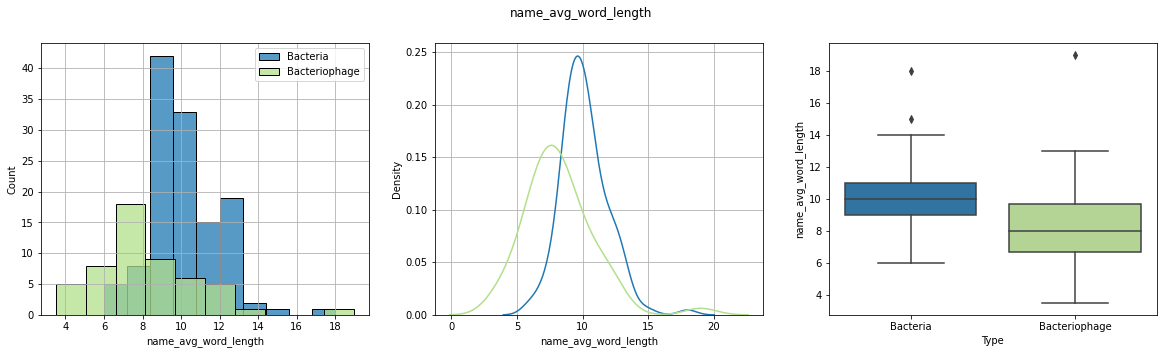

In [66]:
## Plot Name column length features 
hist_compare("name_word_count")
hist_compare("name_char_count")
hist_compare("name_avg_word_length")

Key insights:  
We can see that all bacteria names other then some outliers have 2 words in them.  
On the other hand the Bacteriophage names are more diverse in number of words.

### Polarity analysis

In [67]:
# Add polarity columns
df['Polarity'] = df['Description'].map(lambda text: TextBlob(str(text)).sentiment.polarity)

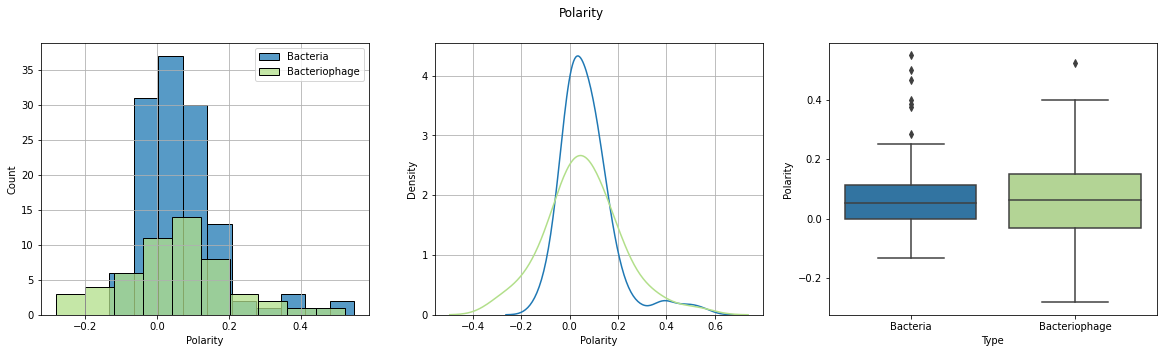

In [68]:
## Plot polatiry
hist_compare("Polarity")

Key insights:  
As expected, both groups have very similar distribution.  
The distribution is distributed normaly around the 0.  
A widder bell curve is seen for the bacteriophage group (can also be attribute to the smaller number of bacteriophages samples).

## Word count

### Word colud

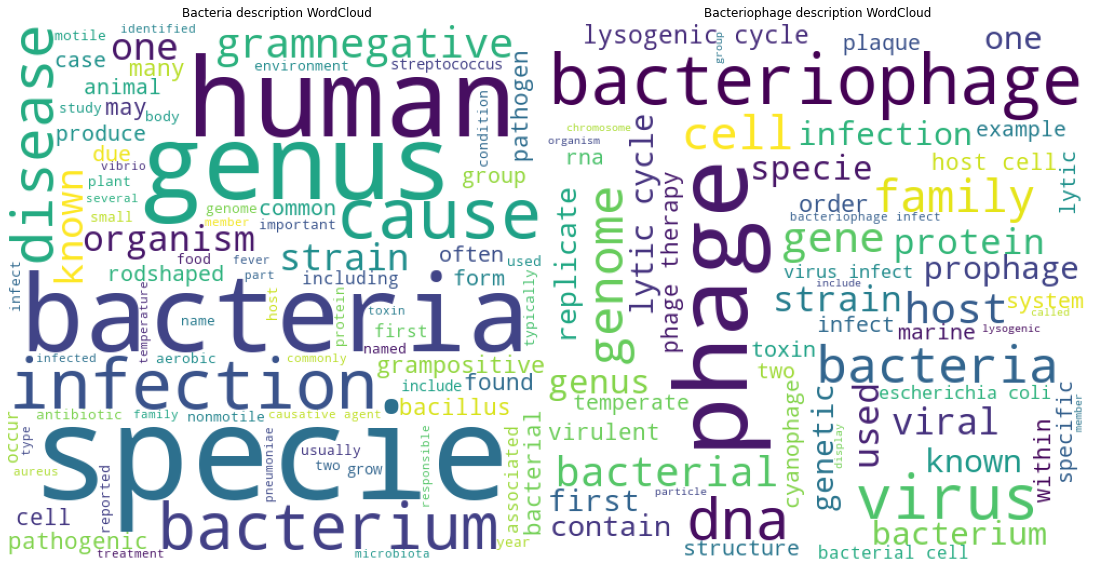

In [69]:
## For the word count we will use the clean text (No stopwords and with lemmitisation of the words)
## Get all description texts
all_desc_bacteria = df.loc[df["Type"]=="Bacteria","Description_clean"]
all_desc_phage = df.loc[df["Type"]=="Bacteriophage","Description_clean"]
# Now let's generate a wordcloud for some reviews
wordcloud_bacteria = WordCloud(width = 500, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(all_desc_bacteria.str.cat())

wordcloud_phage = WordCloud(width = 500, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(all_desc_phage.str.cat())
  
# plot the WordCloud image
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))                        
#plt.figure(figsize = (6, 6), facecolor = None) 
ax1.imshow(wordcloud_bacteria) 
ax1.axis("off") 
ax1.set_title("Bacteria description WordCloud")
ax2.imshow(wordcloud_phage) 
ax2.axis("off") 
ax2.set_title("Bacteriophage description WordCloud")

plt.tight_layout(pad = 0) 
plt.show()

Key insights:   
- The words Human and animal which represent the direct host of the bacteria are visible at the bacteria cloud and not at the bactriophage cloud.  
- The word Bacteria (not like bacteriophage) is presented in both clouds (the word represent the name of one group and the direct host of the other).  

Among the most repetitive words we can find:  
For Bacteria description- bacteria, specie, infection, human, genus, cause and disease.  
For Bacteriophage description- phage, bacteriophage, bacteria, virus, dna.

### Scattertext analysis

In [70]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
import spacy
#display(HTML("<style>.container { width:98% !important; }</style>"))

In [71]:
# We will be using the large English spacy model (pipeline)
!spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

     |████████████████████████████████| 400.7 MB 6.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [72]:
# Prepare parsed data for scattertext analysis
# Tokenize the data with spacy
df['parsed'] = df['Description_clean'].apply(nlp)

In [73]:
# Convert dataframe into Scattertext corpus
corpus = st.CorpusFromParsedDocuments(df, category_col='Type', parsed_col='parsed').build()

In [74]:
# Visuals without stop words
html = st.produce_scattertext_explorer(corpus, category='Bacteria', 
                                       category_name='Bacteria', 
                                       not_category_name='Bacteriophage', 
                                       minimum_term_frequency=5, 
                                       term_significance = st.LogOddsRatioUninformativeDirichletPrior())

In [75]:
#file_name = 'NLP_Exercise/scattertxt_graph.html'
#open(file_name, 'wb').write(html.encode('utf-8'))

In [76]:
import IPython
IPython.display.HTML(filename='NLP_Exercise/scattertxt_graph.html')

Key insights:  
The buttom right corner and the upper left corner show the most distinct frequant tokens for each category.  
- Bacteria: pathogen, rodshaped, agar, gramposative  
- Bacteriophage: phage, bacteriophage, virus, viral

### N-gramming

In [77]:
'''
Function which return the frequancy of the selected gram number for the text
'''
def get_top_n_words(corpus, n=None, x=1, y=1):
    vec = CountVectorizer(ngram_range=(x, y)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

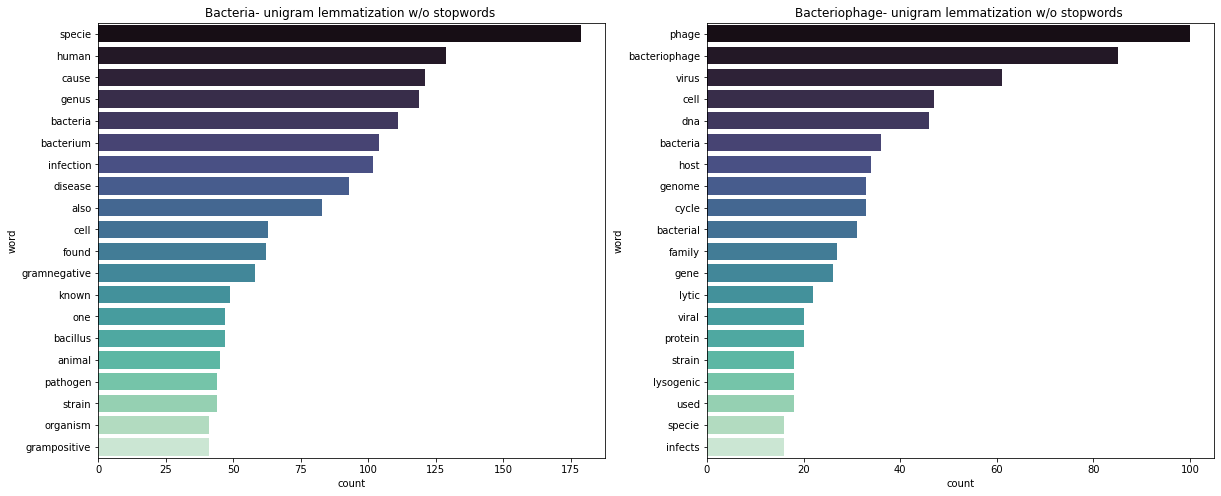

In [78]:
'''
Plotting Unigram of bacteria vs bacteriophage
'''
## Calculating unigram
common_words_bacteria = get_top_n_words(all_desc_bacteria, 20)
common_words_phage = get_top_n_words(all_desc_phage, 20)
unigrams_bacteria = pd.DataFrame(common_words_bacteria, columns = ['word' , 'count'])
unigrams_bacteriophage = pd.DataFrame(common_words_phage, columns = ['word' , 'count'])

## Plotting
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x="count", y="word",orient="h",ax = ax1, palette="mako", data=unigrams_bacteria)
ax1.set_title("Bacteria- unigram lemmatization w/o stopwords ")
sns.barplot(x="count", y="word",orient="h", ax =ax2, palette="mako", data=unigrams_bacteriophage)
ax2.set_title("Bacteriophage- unigram lemmatization w/o stopwords ")
plt.tight_layout
plt.show()

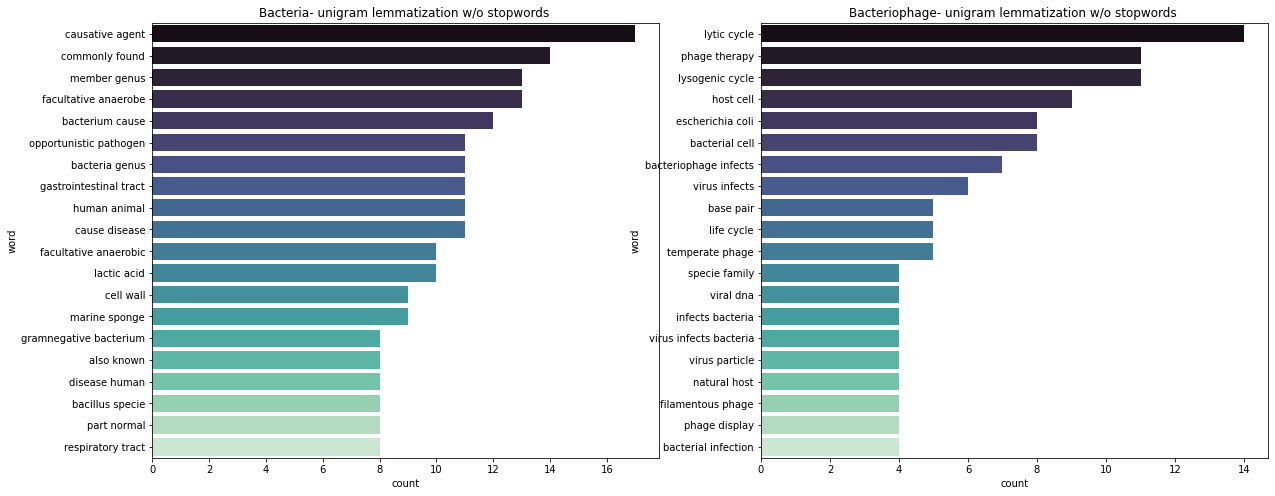

In [79]:
'''
Plotting max of 2 and 3 gram of bacteria vs bacteriophage
'''
## Calculating max 2 and 3 gram 
biotripplegram_bacteria = get_top_n_words(all_desc_bacteria, 20, 2,3)
biotripplegram_phage = get_top_n_words(all_desc_phage, 20, 2,3)
biotripplegram_bacteria = pd.DataFrame(biotripplegram_bacteria, columns = ['word' , 'count'])
biotripplegram_phage = pd.DataFrame(biotripplegram_phage, columns = ['word' , 'count'])

## Plot
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x="count", y="word",orient="h",ax = ax1, palette="mako", data=biotripplegram_bacteria)
ax1.set_title("Bacteria- unigram lemmatization w/o stopwords ")
sns.barplot(x="count", y="word",orient="h", ax =ax2, palette="mako", data=biotripplegram_phage)
ax2.set_title("Bacteriophage- unigram lemmatization w/o stopwords ")
plt.tight_layout
plt.show()

Key insights:  
- The word Bacteria is the only noticable word which overlap between the 2 groups top gram words.  
- Higher number of counts for unigram words then bigram and tripllegram.  
- The words "known", "also" and "used" are not really domain specific. Should consider to remove them?  



### Named-Entity Recognition (NER)

In [80]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
nlp = spacy.load("en_core_web_lg")
## tag text and exctract tags into a list
df["entity_tags"] = df["Description"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in nlp(x).ents] )## utils function to count the element of a list

In [82]:
# Inspect the NERs in the first three descriptions
from spacy import displacy
for i in range(0,3):
  displacy.render(nlp(str(df['Description'][i])), style='ent', jupyter=True)

In [83]:
## Available entities of model
nlp.get_pipe("ner").labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

Key insights:  
The algorithm does not seem to work as good with this data set. A lot of important entities are not recognized or missclassified (e.g. bacteria names).  
The use of a different NER model, more specific to healthcare data or refitting of the current model would be neccessary to receive more reliable results. 

Nevertheless, to stay within the scope of this work, we will continue to explore the data with this model.  
  
**In the following section, we will explore the difference between the average number of entities found for each record by class.**  
One assumption is that a higher number of human-realated (e.g. EVENT) entities can be found in the Bacteria class than the Bacteriophage class. This is due to the direct connected line of humans and bacteria, as can be seen from the wordcloud. (It can also be assumed that those entities would be more correctly classified with this model)


#### Plotting top frequent entity_tags

In [84]:
'''
Function- count the number of time each type of entity appered in the text
'''
def entity_count(lst):
  tmp=[]
  for x in lst:
    tmp.append(x[1])
  
  dict_of_count = {item:tmp.count(item) for item in tmp}
  return  dict_of_count

In [85]:
df["entity_types"] = df["entity_tags"].apply(lambda x: entity_count(x))
ner_labels = list(nlp.get_pipe("ner").labels)

def ner_labels_bow(dic):
  bow_list = []
  for label in ner_labels:
    if label in dic.keys():
      bow_list.append(dic[label])
    else:
      bow_list.append(0)
  return bow_list

## Create a bag of words for the entity types (count how many entities from each type we have for each description)  
df["entity_types"] = df["entity_types"].apply(lambda x: ner_labels_bow(x)) 
df[[i for i in ner_labels]] = pd.DataFrame(df.entity_types.tolist(), index= df.index) ##Create a column for each entity type
df["entity_types"]

0     [1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 3, 0, 4, 2, 0, 0, 0]
1     [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0]
2     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
3     [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 8, 0, 0, 0, 0]
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0]
                               ...                          
49    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
51    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0]
52    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
53    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Name: entity_types, Length: 179, dtype: object

In [86]:
## Creating a new dataframe with a calculate mean value column of the number of entities for each entity by Type
bacteria_entity_mean = df[df["Type"]=="Bacteria"][[i for i in ner_labels]].mean().reset_index()
bacteriophage_entity_mean = df[df["Type"]=="Bacteriophage"][[i for i in ner_labels]].mean().reset_index()
bacteria_entity_mean["Type"]="Bacteria"
bacteriophage_entity_mean["Type"] = "Bacteriophage"
entity_mean = pd.concat([bacteria_entity_mean,bacteriophage_entity_mean], axis=0)
entity_mean.columns = ["entity", "mean", "Type"]
entity_mean.head()

,entity,mean,Type
0,CARDINAL,1.341270,Bacteria
1,DATE,0.658730,Bacteria
2,EVENT,0.039683,Bacteria
3,FAC,0.047619,Bacteria
4,GPE,0.523810,Bacteria


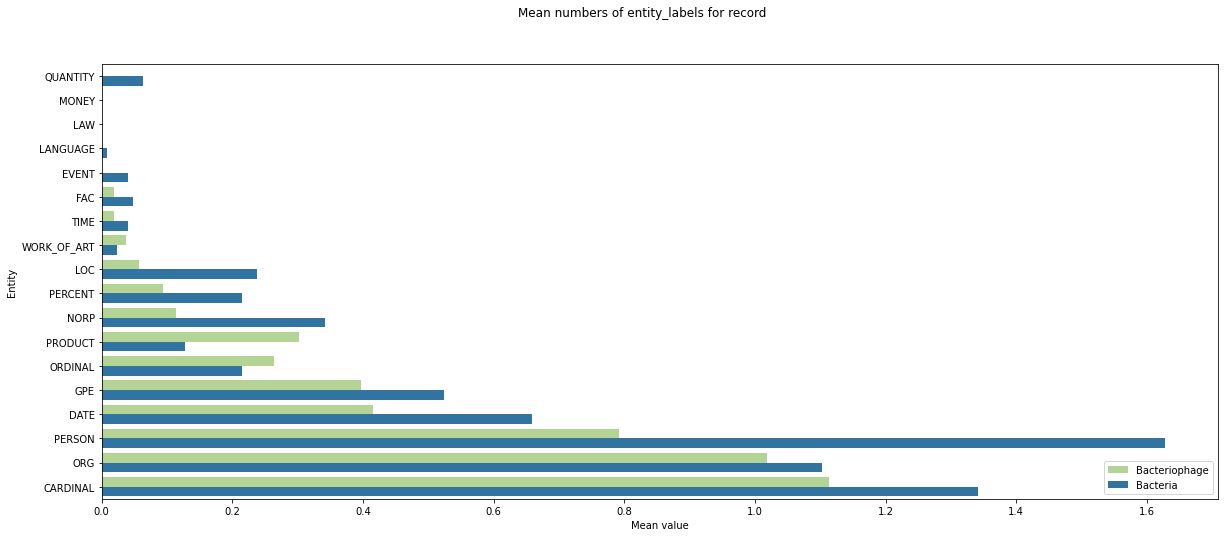

In [87]:
## Plot 
colors = {"Bacteria":'#1f78b4', "Bacteriophage":'#b2df8a'}
fig, (ax1) = plt.subplots(1, figsize=(20,8))
fig.suptitle("Mean numbers of entity_labels for record", fontsize=12)
sns.barplot(x="mean", y="entity", hue= "Type", data=entity_mean.sort_values("mean"), ax=ax1, palette=colors)
ax1.legend(loc='lower right')
ax1.set_ylabel("Entity")
ax1.set_xlabel("Mean value")

plt.show()

Key insights:  
As assumed larger number of EVENTS entities can be seen within the bacteria class (no EVENT entity was dicovered in our dataset in the bacteriophage class), the entity type is rare though also for the bacteriophage class.  
On a similiar note, a larger number of LOC entities can be found within the bacteria class than the bacteriophage class (found in almost ~25% of the descriptions). Those entities probably represent the location of interaction between bacteria and human beings.  
A smaller difference can be found in the GPE and FAC entities.

*NORP: Nationalities or religious or political groups  
*LOC: Non-GPE locations, mountain ranges, bodies of water  
*GPE Countries, cities, states, etc.  
*FAC: Buildings, airports, highways, bridges, etc.


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 53
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  179 non-null    object 
 1   Description           179 non-null    object 
 2   Type                  179 non-null    object 
 3   lang                  179 non-null    object 
 4   Description_clean     179 non-null    object 
 5   word_count            179 non-null    int64  
 6   char_count            179 non-null    int64  
 7   sentence_count        179 non-null    int64  
 8   avg_word_length       179 non-null    float64
 9   avg_sentence_length   179 non-null    float64
 10  name_word_count       179 non-null    int64  
 11  name_char_count       179 non-null    int64  
 12  name_avg_word_length  179 non-null    float64
 13  Polarity              179 non-null    float64
 14  parsed                179 non-null    object 
 15  entity_tags           17

In [89]:
pd.set_option('display.max_columns', None)
df.head(2)

,Name,Description,Type,lang,Description_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,name_word_count,name_char_count,name_avg_word_length,Polarity,parsed,entity_tags,entity_types,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria,en,acinetobacter baumannii typically short almost round rodshaped coccobacillus gramnegative bacter...,354,2118,27,5.983051,13.111111,2,22,11.0,-0.019570,"(acinetobacter, baumannii, typically, short, almost, round, rodshaped, coccobacillus, gramnegati...","[(Paul Baumann, PERSON), (Acinetobacter, LOC), (IV pili, PERSON), (Moraxellaceae, PERSON), (ACB,...","[1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 3, 0, 4, 2, 0, 0, 0]",1,0,1,0,2,0,0,1,0,0,0,3,0,4,2,0,0,0
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria,en,actinomyces israelii specie grampositive rodshaped bacteria within genus actinomyces known live ...,72,383,6,5.319444,12.000000,2,19,9.5,0.221591,"(actinomyces, israelii, specie, grampositive, rodshaped, bacteria, within, genus, actinomyces, k...","[(Actinomyces, ORG), (Actinomyces, ORG), (German, NORP), (James Adolf, PERSON), (Israel, GPE), (...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0]",1,1,0,0,1,0,0,0,0,1,1,2,0,1,0,0,0,0


## Summary


In [90]:
## Summary EDA fast report 
# profile = prof.ProfileReport(df, title="Profile Report wikipedia pages", explorative=True)
# profile.to_file(Path("Summary_profile_report_wikipedia.html"))

The data contains the summary information of various Bacteria species extracted from the "List of clinically important bacteria" page, and information about different Bacteriophages from the "Category: Bacteriophages" page in Wikipedia.
<br>  
Due to the two distinct categorical groups, we explored the data with a classification approach in mind.  
  
The initial combined dataframe contained 180 records and 3 features (name, description and type).  
The main target group column "Type" is unbalanced. When modeling the data it should be rebalanced first.  

After dropping one unwanted row and performing feature engineering, a data frame containing 179 records and 34 features (31 new features) was left:  
- One language column (constant- can be left out)  
- Description_clean - clean version of description column:  
  - Lower case, remove punctuation and stopwords, lemmatization (used to create other features out of it).
- 8 length features - 5 created out of "Description" column and 3 out of "Name"  (including, word/character/sentence count).  
- Polarity column - Calculation of the description column's overall polarity
- parsed - tokenized form of "Description_clean" column (used to create other features out of it).
- entity_tags and entity_types -used to performed BOW count of entities 
- 17 BOW columns of entities.  

  
The effect/correlation of the new features (representing the text properties) to the type column (Bacteria and Bacteriophage categories) was then investigated:  

**Length features - Type**  
We can see a difference in distribution between the length properties of Bacteria and Bacteriophage descriptions. Longer descriptions, in respect to word, character and sentence count, tend to be Bacteria descriptions.  
Bacteria names tend to have two words in them, in rare occasion one and never in our list more than two. Bacteriophage names are more versatile in the word length on the other hand (1,2 or 3 words).  

**Polarity vs Type**  
No significant difference in polarity between the descriptions of the two categories was noticable. Both categories' polarity is evenly distributed around the 0.  

**Word count analysis  Description vs Type**  
The words "human" and "animal" which are the direct hosts of the bacteria are frequently used in the description of bacteria and not frequent when describing bactriophages.
The word Bacteria (not like bacteriophage) is in frequently used in both categories (representing the name of one group and the direct host of the other).  
Among the most repetitive words we can find:  
- For Bacteria description - bacteria, species, infection, human, genus, cause and disease.  
- For Bacteriophage description - phage, bacteriophage, bacteria, virus, DNA.

With the help of the **scatter text analysis**, the most frequent representative words of each category (bacteria and bacteriophage) can be distinguished. Those words can help to classify description text to the right category:  
 - Bacteria - pathogen, rodshape, agar, grampositive ...
 - Bacteriophage - phage, bacteriophage, virus, viral ...

**N-gram analysis vs Type**  
The word "Bacteria" is the only noticable word which overlaps between the two groups' top gram words.  A fact which implies that N-gram analysis could be a good approach to classify the data.
A higher number of counts for unigram words than bigram and triplegram is visible.   
The unigram words "known", "also" and "used" are not really domain specific, therefore their removal should be considered when using N-gram analysis for classification in the model.

**Named-Entity Recognition (NER)**  
Initial use of the model using the spacy model did't yield in satisfying results,therefore a different model, more specific to healthcare data or refitting of the current model would be neccessary to receive more reliable results. 

Nevertheless, to stay within the scope of this work, we explored the data with this model and focused on the entities which we assumed had more relible results by this NER model.  
As assumed larger number of EVENTS entities can be seen within the bacteria class (no EVENT entity was dicovered in our dataset in the bacteriophage class), the entity type is rare though also for the bacteriophage class.  
On a similiar note, a larger number of LOC entities can be found within the bacteria class than the bacteriophage class (found in almost ~25% of the descriptions). Those entities probably represent the location of interaction between bacteria and human beings.  
A smaller difference can be found in the GPE and FAC entities.
